In [1]:
# go wide screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [49]:
import spectrum
s = spectrum.readSpectrum("../data/sf2outcube_COSMOSA_022.fits.gz")
ww = s.grid()
ww[0], ww[-1]
ww[1]-ww[0]

1.9858398000001216

In [59]:
#!/usr/bin/env python

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import spectrum
from astropy.io import ascii
from astropy.io import fits
from scipy import interpolate
import numpy
from matplotlib import pyplot as plot
import skimage.morphology
from scipy.optimize import least_squares
from astropy.stats import biweight_location
import numpy as np
from astropy.table import Table, Column

import matplotlib.pyplot as plt

from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

import matplotlib.pyplot as plt

from astropy import wcs
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

from astroquery.simbad import Simbad
import astropy.coordinates as coord
import astropy.units as u
import os
import pickle

from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter

from astropy.io import ascii
from collections import OrderedDict
import os
from astropy.io import ascii

from scipy.optimize import least_squares
import numpy as np



from scipy.interpolate import interp1d
params = {'legend.fontsize': 'x-small',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-small',
         'axes.titlesize':'x-small',
         'xtick.labelsize':'x-small',
         'ytick.labelsize':'x-small'}
plt.rcParams.update(params)

import matplotlib.pyplot as plt

from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

import glob
from astropy.io import fits
from astropy import wcs
import sys, traceback
import argparse


def register_ds9staircase():
    # register color map
    from matplotlib.cm import register_cmap, cmap_d

    colors = []
    for ii in range(1,6):
        kk = ii/5.
        colors.append( (kk*.3,kk*.3,kk*1)  )

    for ii in range(1,6):
        kk = ii/5.
        colors.append( (kk*.3,kk*1,kk*.3)  )
    for ii in range(1,6):
        kk = ii/5.
        colors.append( (kk*1,kk*.3,kk*.3)  )
    colors = np.array(colors)
    xx = np.arange(len(colors), dtype=float)
    xx = xx/xx.max()

    ds9staircase = {'red': lambda v : np.interp(v, xx, colors[:,0]),
               'green': lambda v : np.interp(v, xx, colors[:,1]),
               'blue': lambda v : np.interp(v, xx, colors[:,2])}


    # Register all other colormaps
    register_cmap('ds9staircase', data=ds9staircase)

register_ds9staircase()



# simple continuum removal though spline interpolation
def confitSpl(wls, s, n = 10, kappaL=2.5, kappaU=2.5, output_fit=False, smooth=0., mask=None, PLOT=False, maxiter=15):
    if mask == None:
        mask_ = wls > -1 # use all
    else:
        mask_ = mask.copy()
    mask_ *= ~ np.isnan(s)
    l = len(wls)
    l = np.floor(l/n)
    dwl = (wls[-1]-wls[0])/n

    niter = 0
    nmasked = len(mask_[~mask_])
    while niter < maxiter:
        bwls = []
        bs   = []

        # put one point at the blue end, window only half the normal binsize
        wlstart = wls[0]
        wlstop  = wls[0] + dwl/2.
        ii = (wls >= wlstart) * (wls <= wlstop)
        if type(mask_) != type(None): ii *= mask_

        binned_wls = np.mean( wls[ii] )
        bwls.append( binned_wls )
        bs.append(    np.median(   s[ii] ) )
        # normal points, normal binsize
        for i in range(n-1):
                wlstart = wls[0]  + dwl/2. + dwl * i
                wlstop  = wls[0]  + dwl/2. + dwl * (i + 1)
                ii = (wls >= wlstart) * (wls <= wlstop)
                if type(mask_) != type(None): ii *= mask_
                binned_wls = np.mean( wls[ii] )
                bwls.append( binned_wls )
                bs.append(    np.median(   s[ii] ) )
        # put one point at the red end, window only half the normal binsize
        wlstart = wls[-1] - dwl/2.
        wlstop  = wls[-1]
        ii = (wls >= wlstart) * (wls <= wlstop)
        if type(mask_) != type(None): ii *= mask_
        binned_wls = np.mean( wls[ii] )
        bwls.append( binned_wls )
        bs.append(    np.median(   s[ii] ) )

        tck = interpolate.splrep(bwls,bs,s=smooth)
        c = interpolate.splev(wls,tck,der=0)

        res = s-c
        sigma = np.std(res[mask_])

        inliers  = ( res) <= kappaU*sigma
        inliers *= (-res) <= kappaL*sigma

        mask_ *= inliers
        nmasked_new = len(mask_[~mask_])
        if nmasked_new == nmasked:
            break
        nmasked = nmasked_new

        niter += 1
    if PLOT:
        f=plt.figure()
        plt.plot(wls,s)
        plt.plot(wls,c)
        plt.plot(wls[~mask_],s[~mask_],'r.')
        plt.ylim([-1.,1.])

    # filter lowest and highest 3 fourier channels
    sc = s-c

    if output_fit:
        return sc,c
    else:
        return sc
    
    

def line_detect(ww, csout, threshold):
    # line detection (everything above cetain threshold)
    jj = csout > threshold

    # labelling line detections
    label = skimage.morphology.label(jj)
    ll = np.unique( label )

    lineset = []
    dlineset = []

    for l in ll:
        if l == 0:
            continue
        ii = l == label
        f = np.sum( csout[ii] )
        wl_com = np.sum( ww[ii]*csout[ii] ) /np.sum(csout[ii] )
        #print("{} {:.2f}A {:.2f}".format(l, wl_com, f))
        lineset.append(wl_com)
        dlineset.append(2.)
    return lineset, dlineset, jj

def masked_biweight(cube_slice, mask):
    return biweight_location( cube_slice[mask] )



def masked_sum(cube_slice, mask):
    return np.sum( cube_slice[mask] )



def extract(r, s, outmap, method=masked_biweight):
    mask = np.sum( outmap == r['id'], axis=0) > 0

    sout = np.zeros( s.data.shape[0]  )
    N = np.sum(mask)
    for i in range(s.data.shape[0]):
        #sout[i] = np.sum( s.data[i][mask] )
        #sout[i] = biweight_location( s.data[i][mask] )*N # statistically stable mean times number of pixel
        sout[i] = method( s.data[i], mask )

    ww = s.grid()
    return ww,sout, mask



def nextract(r, s, outmap, MAX_SAMPLES = 10):
    """
    Shifts the aperture corresponding to a detection around in the noise cube to
    sample the noise N times. The mask is shifted such as to not overlap
    wiht he previous location of the mask

    Original, actual mask
    xxxxxxxxxx
    xxx..xxxxx
    xx...xxxxx
    xxx..xxxxx
    xxxxxxxxxx
    xxxxxxxxxx

    Sample 1
    x..xxxxxxx
    ...xxxxxxx
    x..xxxxxxx
    xxxxxxxxxx
    xxxxxxxxxx
    xxxxxxxxxx

    Sample 2
    xxxxxxxxxx
    xxxxxxxxxx
    xxxxxxxxxx
    x..xxxxxxx
    ...xxxxxxx
    x..xxxxxxx

    Sample 3
    xxxx..xxxx
    xxx...xxxx
    xxxx..xxxx
    xxxxxxxxxx
    xxxxxxxxxx
    xxxxxxxxxx

    Sample 4
    xxxxxxxxxx
    xxxxxxxxxx
    xxxxxxxxxx
    xxxx..xxxx
    xxx...xxxx
    xxxx..xxxx

    Sample 5
    xxxxxxx..x
    xxxxxx...x
    xxxxxxx..x
    xxxxxxxxxx
    xxxxxxxxxx
    xxxxxxxxxx

    Sample 6
    xxxxxxxxxx
    xxxxxxxxxx
    xxxxxxxxxx
    xxxxxxx..x
    xxxxxx...x
    xxxxxxx..x
    """

    mask = np.sum( outmap == r['id'], axis=0) > 0

    # determine masked, region size
    xx = np.arange(mask.shape[1])
    yy = np.arange(mask.shape[0])

    X,Y = np.meshgrid(xx,yy)
    minx,maxx = X[mask].min(), X[mask].max()
    miny,maxy = Y[mask].min(), Y[mask].max()
    sx = maxx - minx + 2
    sy = maxy - miny + 2
    nx,ny = mask.shape[1]//sx, mask.shape[0]//sy

    #f = plt.figure(figsize = [7,7])
    #plt.imshow(mask)

    all_sout = []
    count = 1
    print("Sampling noise in {} separate regions".format( min(nx * ny, MAX_SAMPLES)  ) )
    for i in range(nx):
        if count > MAX_SAMPLES:
            break
        print("Sampling noise row {}".format(i))
        for j in range(ny):
            _mask = mask < 0 # empty mask
            #print(sy*(j), sy*(j+1),sx*(i), sx*(i+1), miny, miny+sy, minx, minx+sx )

            m = mask[miny:miny+sy, minx:minx+sx]
            _mask[sy*(j):sy*(j)+m.shape[0],sx*(i):sx*(i)+m.shape[1]] = m
            #f = plt.figure(figsize = [7,7])
            #plt.imshow(_mask)

            sout = np.zeros( s.data.shape[0]  )
            for k in range(s.data.shape[0]):
                sout[k] = biweight_location( s.data[k][_mask] )
            all_sout.append(sout)
            count += 1

    ww = s.grid()
    return ww, np.array(all_sout), mask
    #plt.imshow(mask)

    
    
def object_description(r):
    s = ""
    uu = [str(r.columns[c].unit) for c in r.columns]
    for n,u in zip(r.colnames, uu):
        s += "{:8s} {} [{}]\n".format(n, r[n], u)

    return(s)



def identify_lines(wldetect, lineset, dlineset, flinelist):
    # detected line must be first line in list
    idetect = np.argmin( np.abs(lineset - wldetect) )
    _lineset = [lineset[idetect]]
    for l in lineset:
        if not l == _lineset[0]:
            _lineset.append(l)

    # http://classic.sdss.org/dr6/algorithms/linestable.html
    t = ascii.read(flinelist)

    for i,(l,dl) in enumerate(zip(_lineset,dlineset)):
        z = l/t["wl[A]"]-1.
        c = Column(z, name="z_{}".format(i))
        t.add_column(c)
        dz = (l+dl)/t["wl[A]"] - (l-dl)/t["wl[A]"]
        c = Column(dz, name="dz_{}".format(i))
        t.add_column(c)
    s = ""


    for r in t:
        if r["z_0"] < 0.:
            continue
        s += "If {:.2f}A is [{:12s}] @ restwl = {:.1f}A (z = {:.2f})\n".format(_lineset[0], r["species"], r["wl[A]"], r["z_0"])
        for i in range(1, len(_lineset)):
            if i == idetect:
                continue
            ii = np.abs( r["z_0"] - t["z_{}".format(i)] ) < (r["dz_0"] + t["dz_{}".format(i)])

            #print("{} lines match ".format(sum(ii)))
            for _r in t[ii]:

                obswl = (_r["wl[A]"] * (1. + r["z_0"]) )
                dA = _lineset[i] - obswl
                dv = dA/lineset[i] * 3e5
                #z = _r["wl[A]"]
                z = _lineset[i]/_r["wl[A]"] - 1.
                s += " {:.2f} could be [{:12s}] @ restwl {}, \n  wl_obs(z={:.2f})={:.2f}A, dA={:.2f}A, dv={:.2f}kms, z={:.2f}\n".format(_lineset[i], _r["species"], _r["wl[A]"],r["z_0"],obswl, dA, dv, z)
    return s


def draw_line(ax, wl, label):
    ymin,ymax = ax.get_ylim()
    ax.text(wl-5.,ymax, label, rotation=90., ha='right', size=10, va='top')
    ax.plot([wl]*2,[0.,.7], c='grey', lw=1., zorder=0)

    
def show_cog(ax1, ax2, ax3, ax4, field, s, r, max_cog_radius = 7.5, max_cut_radius = 12., wl_extent=75.):
    x_com, y_com, z_com, wl_com = r["x_com"], r["y_com"],  r["z_com"], r["wl_com"]
    #print("x_com, y_com, z_com, wl_com : ", x_com, y_com, z_com, wl_com)
    hdu = s.hdu
    c = s.data

    pixelscale = 0.5
    rr = np.arange(0,max_cog_radius/pixelscale,.5)
    xx,yy = np.arange( c.shape[2] ), np.arange( c.shape[1] )
    #zz,yy,xx = [np.arange(s, dtype=int) for s in c.shape]
    XX,YY = np.meshgrid(xx,yy)

    ix = int( np.round(x_com) )
    iy = int( np.round(y_com) )
    iz = int( np.round(z_com) )
    dd = np.sqrt( (XX-x_com)**2. + (YY-y_com)**2. )

    cog = []
    for r in rr:
        ii = dd*pixelscale <= r
        flux = np.sum(c[iz,ii])
        cog.append([r*pixelscale,flux])

    cog = np.array(cog)
    ax1.plot(cog[:,0], cog[:,1]/np.max(cog[:,1]),'x')
    ax1.set_xlabel("r [arcsec]")
    ax1.set_ylabel("cum. flux [arb]")
    
    
    tcal = ascii.read("specphot/cog_{}.txt".format(field), format="fixed_width")
    ax1.plot( tcal["r"], tcal["EE"] ,'-', c='b', alpha=0.5)
    
    ax1.set_xlim([0.,max_cog_radius])
    
    


    #c[iz,:,ix]

    xx = (XX[iy,:]-x_com)*pixelscale
    yy = (YY[:,ix]-y_com)*pixelscale
    ii = np.abs(xx) <= max_cut_radius
    jj = np.abs(yy) <= max_cut_radius

    ax2.plot(xx[ii], c[iz,iy,ii],'-', label="xcut", drawstyle='steps-mid')
    #ax2.plot(yy[jj], c[iz,jj,ix],'-', label="ycut", drawstyle='steps-mid')
    ax2.set_xlabel("[arcsec]")
    #ax2.set_ylabel("flux [arb]")
    #ax3.axes.get_xaxis().set_visible(False)
    #ax3.xaxis.tick_top()
    #ax2.tick_params(labelbottom='off',labeltop='on')
    ax2.xaxis.tick_top()
    ax2.xaxis.set_ticks_position('top') # THIS IS THE ONLY CHANGE
    ax2.xaxis.set_label_position('top')
    ax2.text(0.02,.98,"xcut",va="top", ha="left", transform=ax2.transAxes)

    #ax2.plot(xx[ii], c[iz,iy,ii],'-', label="xcut", drawstyle='steps-mid')
    ax3.plot(yy[jj], c[iz,jj,ix],'-', label="ycut", drawstyle='steps-mid')
    #ax3.set_xlabel("$\Delta$y [arcsec]")
    ax3.axes.get_xaxis().set_visible(False)
    ax3.text(0.02,.98,"ycut",va="top", ha="left", transform=ax3.transAxes)
    ax3.set_ylabel("")

    ww = s.grid()
    kk = np.abs(ww-wl_com) <=   wl_extent/2
    ax4.plot(ww[kk]-wl_com, c[kk,iy,ix],'-', label="wlcut", drawstyle='steps-mid')
    ax4.set_xlabel("$\Delta$wl [A]")
    ax4.set_ylabel("")
    ax4.text(0.02,.98,"zcut",va="top", ha="left", transform=ax4.transAxes)
    #ax4.axes.get_yaxis().set_visible(False)



    
def query_simbad(ra,dec,radius):
    fcache = "../simbad_cache/{:.6f}_{:.6f}_{:.6f}.pickle".format(ra,dec,radius)
    customSimbad = Simbad()

    customSimbad.get_votable_fields()

    if os.path.exists(fcache):
        print("Found SIMBAD cache file {} ...".format(fcache))
        return pickle.load( open( fcache, "rb" ) )
    # else

    # To set other fields

    customSimbad.add_votable_fields('mk', 'rot', 'bibcodelist(1800-2014)', 'z_value','pmra')
    customSimbad.get_votable_fields()
    customSimbad.add_votable_fields('ra(2;A;ICRS;J2017.5;2000)', 'dec(2;D;ICRS;2017.5;2000)')
    customSimbad.remove_votable_fields('coordinates')
    #customSimbad.query_object("HD189733")

    #result_table = customSimbad.query_region("150.143175 2.114586")

    #result_table = customSimbad.query_region(coord.SkyCoord("150.143175 2.114586", frame='fk5'), radius='0d0m10s')

    result = customSimbad.query_region(coord.SkyCoord(ra=ra, dec=dec,
                                        unit=(u.deg, u.deg), frame='fk5'),
                                        radius=radius * u.deg,
                                        epoch='J2000',
                                        equinox=2000)

    from astropy.coordinates import SkyCoord
    cc = [SkyCoord(r, a, unit=(u.hourangle, u.deg)) for r,a in           zip(result["RA_2_A_ICRS_J2017_5_2000"], result["DEC_2_D_ICRS_2017_5_2000"])]

    aa = [c.ra.deg for c in cc]
    dd = [c.dec.deg for c in cc]

    result =  [[id,a,d,z] for id,a,d,z in zip(result["MAIN_ID"], aa,dd, result["Z_VALUE"])]

    pickle.dump( result, open( fcache, "wb" ) )

    return result





def show_image(ax, r, hdu, w, title, width = 20./3600., AXLABELS=True, photz_catalog=[], vmin=-2.e-5,vmax=10.):
    ra,dec = r["ra_com"], r["dec_com"]
    cos_term = np.cos(np.deg2rad(dec))
    #cos_term=1.
    x0,y0 = w.wcs_world2pix(ra - width/2./cos_term ,dec-width/2.,0)
    x1,y1 = w.wcs_world2pix(ra + width/2./cos_term, dec+width/2.,0)
    x,y = w.wcs_world2pix(ra,dec,0)

    #print("show_image ", vmin, vmax)
    plt.imshow(hdu.data, vmin=vmin, vmax=vmax, origin='lower', interpolation='nearest')
    plt.plot([x],[y],'x',c='white', ms=15)
    ax.set_xlim([x1,x0])
    ax.set_ylim([y0,y1])

    ax.text(0.05,0.05,title,transform=ax.transAxes, color='white')

    ax.set_xlabel("RA")
    ax.set_ylabel("Dec")
    
    plt.imshow(hdu.data, vmin=vmin, vmax=vmax, origin='lower', interpolation='nearest')
    xlim = plt.xlim()
    ylim = plt.ylim()    
    
    if photz_catalog != []:
        xx,yy = w.wcs_world2pix(photz_catalog["ra"],photz_catalog["dec"],0)
        zz = photz_catalog["z"]
        ii = (xx >= xlim[0]) * (xx <= xlim[1]) * (yy >= ylim[0]) * (yy <= ylim[1])
        plt.plot(xx[ii],yy[ii],'o',c='None', ms=5, markeredgecolor='white')

        for x,y,z in zip(xx[ii],yy[ii],zz[ii]):
            plt.text(x+2.,y+2., "z={:.3f}".format(z), color='white',fontsize=6)

    if not AXLABELS:
        ra = ax.coords[0]
        dec = ax.coords[1]
        ra.set_ticks_visible(False)
        ra.set_ticklabel_visible(False)
        dec.set_ticks_visible(False)
        dec.set_ticklabel_visible(False)
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.axis('off')


    
   
#generic gaussian
def gauss(mu, sigma, x):
    return 1./(sigma * np.sqrt(2. * np.pi) ) * np.exp( -(x-mu)**2./(2. * sigma**2.))

def peval(p,x):
    A,mu,sigma = p
    return A*gauss(mu, sigma, x)

def resid(p, x, y, yerr=[]):
    model = peval(p,x)
    if yerr==[]:
        return (y - model)
    else:
        return (y - model)/yerr

def fit_gaussians(lineset, ww, csout, wlwin, pp=[]):
    results = []

    for i,wlc in enumerate(lineset):
        if pp != []:
                p0 = pp[i]
        else:
            p0 = [2000.,wlc,10.]
        ii = (ww > wlc-wlwin/2.) * (ww < wlc+wlwin/2.)
        ii *= ~ np.isnan(csout)
        fit = least_squares(resid, p0, args=(ww[ii], csout[ii]))
        p = fit.x

        if False:
            f=plt.figure()

            plt.plot(ww[ii], csout[ii])
            plt.plot(ww[ii], peval(p,ww[ii]))

        results.append([p[0], p[1],p[2]])

    results = np.array(results)


    return results

def fit_peak( ww, csout_unsmoothed,  r, win ):

    ff = csout_unsmoothed
    #yerr = np.std(nsout,axis=0)
    ii = (ww > (r["wl_com"] - win/2.)) * (ww < (r["wl_com"] + win/2.))
    ii *= ~ np.isnan(csout_unsmoothed)

    dw = ww[1]-ww[0]

    A0 = np.sum(ff[ii]) * dw
    mu0    = r["wl_com"]
    sigma0 = r["dwl"]
    p0=[A0,mu0,sigma0]

    #fit = least_squares(resid, p0, args=(ww[ii],ff[ii],yerr[ii]))
    fit = least_squares(resid, p0, args=(ww[ii],ff[ii]))
    p = fit.x
    #print(fit.x)
    ii = (ww > (p[1] - win/2.)) * (ww < (p[1] + win/2.))
    ii *= ~ np.isnan(ff)
    # refit with better centroid
    fit = least_squares(resid, p0, args=(ww[ii],ff[ii]))
    p = fit.x
    #print(fit.x)

    if False:
        f = plt.figure()
        plt.plot(ww[ii],ff[ii])
        plt.errorbar(ww[ii],ff[ii],yerr[ii])
        plt.plot(ww[ii],peval(p,ww[ii]))
        #ax1.fill_between(ww, yerr, -yerr,alpha=0.2, edgecolor='black', facecolor='grey')
    return p

def add_line_indicators(ax, wldetect, flinelist, candidates = [["Lyα", 1215.24,"red",-20.,-.0025],["OII",3727.1,"green",+20.,-.005]]):
    ymin,ymax = ax.get_ylim()
    xmin,xmax = ax.get_xlim()
    width = 15.
    t = ascii.read(flinelist)
    for cand_name,cand_wl,cand_color,xoff,yoff in candidates:
        z = wldetect/cand_wl - 1.
        for r in t:
            wl = r["wl[A]"] * (1. + z)
            if not (wl >= xmin and wl <= xmax):
                continue
            ax.plot([wl-width/2.-0.05, wl+width/2.], [ymax+yoff,ymax+yoff], c=cand_color, linewidth=1.)

            sinfo  = "{}".format(r["species"])
            if r["species"] == cand_name:
                sinfo += " z={:.3f}".format(z)
            ax.text(wl+xoff, ymax+0.02+yoff, sinfo , rotation=90., ha='center',va='bottom', color=cand_color)

    ax.set_xlim([xmin,xmax])

def plot_spec_orig(ax1, ax2, ww, csout, nsout, wldetect, jj, results, r, s, bad = [[5275.,5325.]]):
    global layoutmode
    #f = plt.figure(figsize = [15,10])
    #ax1 = plt.axes()
    ax1.axvline(wldetect, c='r')

    ax1.plot(ww, csout, drawstyle='steps-mid')
    mm = np.std(nsout,axis=0)
    ax1.fill_between(ww, 5.*mm, -5.*mm,alpha=0.2, edgecolor='black', facecolor='grey')
    ax1.fill_between(ww, 2.*mm, -2.*mm,alpha=0.2, edgecolor='black', facecolor='grey')
    ax1.fill_between(ww, mm, -mm,alpha=0.2, edgecolor='black', facecolor='grey')
    ax1.set_xlabel("wl[A]")

    ii_bad = ww < 0.
    for b in bad:
        ax1.axvspan(b[0], b[1], alpha=0.5, color='grey')
        ii_bad += (ww > b[0]) * (ww < b[1])

    ax1.plot(ww[~ii_bad * jj], csout[~ii_bad * jj], 'r.')
    ax1.axes.get_yaxis().set_visible(False)

    pad = 30
    minz, maxz = 0,s.data.shape[0]
    z1,z2 = max(r["zmin"]-pad,minz),min(r["zmax"]+pad,maxz)


    # zoom in on detection line
    ax2.plot(ww[z1:z2], csout[z1:z2], drawstyle='steps-mid')
    
    if not layoutmode:
        ax2.fill_between(ww[z1:z2], 5.*mm[z1:z2], -5.*mm[z1:z2],alpha=0.2, edgecolor='black', facecolor='grey')
        ax2.fill_between(ww[z1:z2], 2.*mm[z1:z2], -2.*mm[z1:z2],alpha=0.2, edgecolor='black', facecolor='grey')
        ax2.fill_between(ww[z1:z2], mm[z1:z2], -mm[z1:z2],alpha=0.2, edgecolor='black', facecolor='grey')


    ax2.set_ylim([-.15,.35])
    ax2.set_xlabel("wl[A]")
    ax2.set_ylabel("mean flux \n[$10^{-18}$ $erg$ $s^{-1}$ $cm^{-2}$ $A^{-1}$ $arcsec^{-2}$]")
    ylim = ax2.get_ylim()
    ax1.tick_params(size=5)


    #xaxis = ax1.coords[0]
    #yaxis = ax1.coords[1]
    #xaxis.set_ticks_visible(False)
    #xaxis.set_ticklabel_visible(False)
    #yaxis.set_ticks_visible(False)
    #yaxis.set_ticklabel_visible(False)
    ax1.set_ylabel("")
    #ax1.set_xlabel("wl[A]")

    if len(results) > 0:
        ii = (results[:,1] > ww[0]) * (results[:,1] < ww[-1])
        results = results[ii]
        for r in results:
            #s = "line {:.1f}A {:.1f}s\n{:.4e}erg/s/cm^2".format(r[1],r[2], r[0]*cal_interp(r[1]) )
            s = "{:.1f}A ".format(r[1],r[2] )
            #print(s)
            draw_line(ax1, r[1], s)
            
    ax1.set_xlim([3510.,5500.])

    
# this version for the HETDEX proposal
def plot_spec(ax1, ax2, ww, csout, nsout, wldetect, jj, results, r, s, bad = [[5275.,5325.]]):
    
    res_elem_size = 5.
    spec_pix_size = ww[1]-ww[0]
    bin_size = res_elem_size/spec_pix_size
    sqrt_bin_size = np.sqrt(bin_size)
    
    print("bin_size = ", bin_size)
    
    global layoutmode
    ax1.axvline(wldetect, c='r')

    # main spectral plot
    ax1.plot(ww, csout*bin_size*10., drawstyle='steps-mid')
    # errorbands
    mm = np.std(nsout,axis=0)
    #ax1.fill_between(ww, 5.*mm*sqrt_bin_size, -5.*mm*sqrt_bin_size,alpha=0.2, edgecolor='black', facecolor='grey')
    ax1.fill_between(ww, 3.*mm*sqrt_bin_size*10., -3.*mm*sqrt_bin_size*10.,alpha=0.2, edgecolor='black', facecolor='grey')
    #ax1.fill_between(ww, mm*sqrt_bin_size, -mm*sqrt_bin_size, alpha=0.2, edgecolor='black', facecolor='grey')
    ax1.set_xlabel("wl[A]")

    ii_bad = ww < 0.
    for b in bad:
        ax1.axvspan(b[0], b[1], alpha=0.5, color='grey')
        ii_bad += (ww > b[0]) * (ww < b[1])

    ax1.plot(ww[~ii_bad * jj], csout[~ii_bad * jj]*bin_size*10., 'r.')
    ax1.axes.get_yaxis().set_visible(False)

    pad = 30
    minz, maxz = 0,s.data.shape[0]
    z1,z2 = max(r["zmin"]-pad,minz),min(r["zmax"]+pad,maxz)


    # zoom in on detection line
    ax2.plot(ww[z1:z2], csout[z1:z2]*bin_size*10., drawstyle='steps-mid')
    
    if not layoutmode:
        ax2.fill_between(ww[z1:z2], 3.*mm[z1:z2]*sqrt_bin_size*10., -3.*mm[z1:z2]*sqrt_bin_size*10.,alpha=0.2, edgecolor='black', facecolor='grey')


    ax2.set_ylim([-.53*10.,.9*10.])
    ax2.set_xlabel("wl[A]")
    ax2.set_ylabel("mean line flux \n[$10^{-19}$ $erg$ $s^{-1}$ $cm^{-2}$ $arcsec^{-2}$]")
    ylim = ax2.get_ylim()
    ax1.tick_params(size=5)


    ax1.set_ylabel("")

    if len(results) > 0:
        ii = (results[:,1] > ww[0]) * (results[:,1] < ww[-1])
        results = results[ii]
        for r in results:
            s = "{:.1f}A ".format(r[1],r[2] )
            draw_line(ax1, r[1], s)
            
    ax1.set_xlim([3510.,5500.])

    
    

def plot_3D_array_slices(ax, s, r, dz=[-1,0,1], alpha=[0.1,1.,0.1], min_val=0.,max_val=0.5):
    colormap = plt.get_cmap('ds9staircase')
    c = s.data
    ww = s.grid()
    pad = 15
    z_com = r["z_com"]

    minx, maxx = 0,c.shape[2]
    miny, maxy = 0,c.shape[1]
    minz, maxz = 0,c.shape[0]

    z1,z2 = max(r["zmin"]-pad,minz),min(r["zmax"]+pad,maxz)
    y1,y2 = max(r["ymin"]-pad,miny),min(r["ymax"]+pad,maxy)
    x1,x2 = max(r["xmin"]-pad,minx),min(r["xmax"]+pad,maxx)



    platescale = s.hdu.header['CDELT2']*3600.

    ystart = (y1 - r["y_com"])*platescale
    ystep = platescale
    xstart = (x1 - r["x_com"])*platescale
    xstep = platescale

    #n_x, n_y, n_z = array.shape
    n_z, n_y, n_x = c.data.shape

    islice = np.argmax(alpha)

    iz_com = int(np.round(z_com))
    for z,a in zip(dz, alpha):
        #print(iz_com+z)
        z_cut = c[iz_com+int(z),y1:y2,x1:x2]
        #X, Y = np.mgrid[x1:x2, y1:y2]
        X, Y = np.meshgrid(np.arange(x1,x2), np.arange(y1,y2))
        Y = Y  * ystep + ystart
        X = X  * xstep + xstart
        Z = (iz_com * np.ones_like(X) + z) * s.step + s.start

        #ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=colormap((z_cut-min_val)/(max_val-min_val)), shade=False, alpha=a)
        #print(X.shape, Y.shape, Z.shape, z_cut.shape)
        ax.plot_surface(X, Z, Y,  rstride=1, cstride=1, facecolors=colormap((z_cut-min_val)/(max_val-min_val)), shade=False, alpha=a)
    wl = ww[iz_com] + dz[islice]* s.step
    ax.set_title("$\lambda$ = {:.1f} A".format(wl))

    ax.set_ylabel("wavelength [A]")
    ax.set_xlabel("x [arcsec]")
    ax.set_zlabel("y [arcsec]")

    ax.xaxis.labelpad=4
    ax.yaxis.labelpad=4
    ax.zaxis.labelpad=4

def do_slices(r, s, axx, dz = [-4,0,4]):

    dz = np.array(dz) + 0
    if not len(dz) == len(axx):
        print("Error, da and axx must be the same length.")
        return

    for i,ax in enumerate(axx):
        alpha = [0.03] * len(dz)
        alpha[i] = 1.
        plot_3D_array_slices(ax, s, r, dz=dz, alpha=alpha )
        

def get_image_catalog(image_dir = "../aux/thumbnails"):
    #ff = glob.glob(os.path.join( image_dir, pattern ))

    image_catalog = OrderedDict()

    ct = ascii.read( os.path.join(image_dir, "catalog.txt") , format='fixed_width')

    for t,b,f in zip(ct['telescope'],ct['band'],ct['file']):
            f = os.path.join(image_dir, f)
            hdu = fits.open(f)
            w = wcs.WCS(hdu[0].header)
            image_catalog[f] = [w, hdu[0].data.shape, t, b]

    return image_catalog


def show_slice(ax, s, r, cal_interp, width = 20./3600., vmin=0., vmax=.5):
    ra,dec = r["ra_com"], r["dec_com"]

    hdu = s.hdu
    w = WCS(hdu.header)
    w = w.dropaxis(2)
    colormap = plt.get_cmap('ds9staircase')
    sl = hdu.data[int(np.round(r["z_com"]))]
    cos_term = np.cos(np.deg2rad(dec))

    sl[sl == 0] = np.nan
    #current_cmap = plt.cm.get_cmap()
    colormap.set_bad(color='grey')

    #print("np.isnan(sl).all()", np.isnan(sl).all() )

    ax.imshow(sl, vmin=vmin, vmax=vmax, origin='lower', interpolation='nearest', cmap=colormap)
    x0,y0 = w.wcs_world2pix(ra - width/2./cos_term ,dec-width/2.,0)
    x1,y1 = w.wcs_world2pix(ra + width/2./cos_term, dec+width/2.,0)
    x,y = w.wcs_world2pix(ra,dec,0)
    ax.plot([x],[y],'x',c='white')

    #ax.contour(sl, levels=[0.1,0.2,0.3,0.4], colors='grey', alpha=0.5)

    ax.set_xlim([x1,x0])
    ax.set_ylim([y0,y1])

    #ax.set_xlabel("RA")
    #ax.set_ylabel("Dec")

    return sl

def show_collased(ax, s, r, cal_interp, width = 20./3600., vmin=0., vmax=10.):
    A = 0.5**2.
    print("show_slice new 2")
    ra,dec = r["ra_com"], r["dec_com"]

    hdu = s.hdu
    w = WCS(hdu.header)
    w = w.dropaxis(2)
    colormap = plt.get_cmap('ds9staircase')

    ww = s.grid()
    dwl = ww[1] - ww[0]
    #ii  = ww > r["wl_com"] - 50./2.
    #ii *= ww < r["wl_com"] + 50./2.
    #sl = hdu.data[int(np.round(r["z_com"]))]


    sl = np.sum( hdu.data[r["zmin"]:r["zmax"]], axis=0)


    sl = sl * cal_interp( r["wl_com"]) * dwl/A * 1e18

    cos_term = np.cos(np.deg2rad(dec))



    sl[sl == 0] = np.nan
    #current_cmap = plt.cm.get_cmap()
    colormap.set_bad(color='grey')

    #print("np.isnan(sl).all()", np.isnan(sl).all() )

    cax = ax.imshow(sl, vmin=vmin, vmax=vmax, origin='lower', interpolation='nearest', cmap=colormap)
    #cax = ax.imshow(sl, origin='lower', interpolation='nearest', cmap=colormap)
    x0,y0 = w.wcs_world2pix(ra - width/2./cos_term ,dec-width/2.,0)
    x1,y1 = w.wcs_world2pix(ra + width/2./cos_term, dec+width/2.,0)
    x,y = w.wcs_world2pix(ra,dec,0)
    ax.plot([x],[y],'x',c='white')

    cb = plt.colorbar(cax, orientation='horizontal')
    cb.set_label('10$^{-18}$erg s$^{-1}$ cm$^{2}$ arcsec$^{-2}$')

    ax.set_xlim([x1,x0])
    ax.set_ylim([y0,y1])

    ax.set_xlabel("RA")
    ax.set_ylabel("Dec")

    return sl


def convert(p):
    w,h,x,y = p
    return x/1024.,  (768.-y-h)/768. , w/1024., h/768.


def show_NB_image(ax, r, c, w, cal_interp, wlstart, wlend, vmin=0., vmax=5.,sigma=1.2, A_pix = 0.5**2.):
    ww = c.grid()

    ii =  ww >= wlstart
    ii *= ww <= wlend
    
    #collapse slice 
    NB = np.sum(c.data[ii], axis=0)
    
    wwcentral = (ww[ii][0] + ww[ii][-1] )/2.
    wwdelta = ww[ii][-1] - ww[ii][0]

    # calibrate

    calim = NB * cal_interp(wwcentral) / A_pix
    #sigma=1.5 # px = 1 arcsec

    colormap = plt.get_cmap('ds9staircase')

    calim[calim == 0.] = np.nan
    colormap.set_bad(color='grey')

    if sigma > 0.:
        image = ax.imshow(gaussian_filter(calim, sigma)*1e18, vmin=vmin, vmax=vmax, origin='lower', \
                          interpolation='nearest', cmap=colormap)    
    else:
        image = ax.imshow(calim*1e18, vmin=vmin, vmax=vmax, origin='lower', interpolation='nearest', cmap=colormap)
    
    ra,dec = r['ra_com'], r['dec_com']
    x,y = w.wcs_world2pix(ra,dec,0)
    
    cbar = ax.figure.colorbar(image)
    plt.text(.6, .97, "wl$_{{cen}}$ = {:.1f} $\AA$\n$\Delta\lambda = {:.1f}\AA$"\
             .format(wwcentral, wwdelta), transform=ax.transAxes, color='white', va='top')
    plt.plot(x, y, 'x',c='w')
    cbar.set_label("10$^{-18}$ erg s$^{-1}$ arcsec$^{-2}$")
    #cbar.set_ticks([0,.5,1.,1.5,2.])

    xcoll = np.nansum(calim,axis=0)
    ycoll = np.nansum(calim,axis=1)
    xx = np.arange(calim.shape[1])
    yy = np.arange(calim.shape[0])
    ymin = np.nanmin( yy[ycoll > 0.] ) 
    ymax = np.nanmax( yy[ycoll > 0.] ) 
    xmin = np.nanmin( xx[xcoll > 0.] ) 
    xmax = np.nanmax( xx[xcoll > 0.] ) 
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax]) 


def mk_detection_plot(field, IFU, id, r, s, sraw, ns, outmap, image_catalog, threshold, wlwin, width, cal_interp, layoutmode, SKIPERRSPEC=False, filename_appendix="", max_cog_radius=10.):

    print("filename_appendix ", filename_appendix)


    figname = "../catalog_plots/{}/catalog_{}_{}{}.pdf".format(field,IFU, int(id), filename_appendix)
    print("figname ", figname)
    if os.path.exists(figname):
        print("Figure {} already exists. Skipping.".format(figname))
        return

    wldetect = r['wl_com']
    ww, sout, mask    = extract(r, s, outmap)
    ww, sout_unsmoothed, __  = extract(r, sraw, outmap, method=masked_sum)

    if not SKIPERRSPEC and not layoutmode:
        ww,nsout, mask = nextract(r, ns, outmap, MAX_SAMPLES = 100)

    if any( np.isnan(sout) ):
        print("Extraction of object {} resulted in nans in the spectrum.".format(r['id']))
        return

    # continuum removal
    csout            = confitSpl(ww, sout, PLOT=False)
    csout_unsmoothed = confitSpl(ww, sout_unsmoothed, PLOT=False)

    # line detection and gaussian fitting
    lineset, dlineset, jj = line_detect(ww, csout, threshold)
    slineident = ""
    results = []
    if len(lineset) != 0:
        results     =  fit_gaussians(lineset, ww, csout, wlwin = wlwin)
        ii = (results[:,1] > ww[0]) * (results[:,1] < ww[-1])
        results = results[ii] # don't bother with bogus detections
        lineset = np.array(lineset)[ii]
        if len(lineset) != 0:
            results_cal =  fit_gaussians(lineset, ww, csout_unsmoothed, wlwin = wlwin, pp=results)
            # line identification
            slineident = identify_lines(wldetect, lineset,dlineset, flinelist)

    # plottting
    grid_size = (4, 7)
    # 3D plots
    fig = plt.figure(figsize=[18,15])

    ax_info = plt.axes(convert(ax_pos["info"]))
    sod  = "IFU {}\n".format(IFU)
    sod += object_description(r)
    ax_info.text(.0, 1.,sod, ha='left', va='top', size=8)
    ax_info.axis('off')

    if False:
        # 3D slices
        ax_slica3dA = plt.axes(convert(ax_pos["slica3dA"]), projection='3d')
        ax_slica3dB = plt.axes(convert(ax_pos["slica3dB"]), projection='3d')
        ax_slica3dC = plt.axes(convert(ax_pos["slica3dC"]), projection='3d')
        if not layoutmode:
            do_slices(r, s, [ax_slica3dA, ax_slica3dB, ax_slica3dC])


        ax_cog = plt.axes(convert(ax_pos["cog"]))
        ax_xcut = plt.axes(convert(ax_pos["xcut"]))
        ax_ycut = plt.axes(convert(ax_pos["ycut"]))
        ax_wlcut = plt.axes(convert(ax_pos["wlcut"]))
        show_cog(ax_cog, ax_xcut, ax_ycut, ax_wlcut, field, s, r, max_cog_radius=max_cog_radius, max_cut_radius = 12., wl_extent=75.)

    if False:
        # spectra
        ax7 = plt.axes(convert(ax_pos["spectrum"]))
        ax6 = plt.axes(convert(ax_pos["spectrum_inset"]), sharey=ax7)
        A = (s.hdu.header["CDELT2"]*3600.)**2.
        if not SKIPERRSPEC  and not layoutmode:
            plot_spec(ax7, ax6, ww, csout*cal_interp(ww)*1e18/A, nsout*cal_interp(ww)*1e18/A, wldetect, jj, results, r, s, bad = [[5275.,5325.]])
            add_line_indicators(ax7, wldetect, flinelist)
        else:
            print("Foo")
            plot_spec(ax7, ax6, ww, csout*cal_interp(ww)*1e18/A, np.zeros_like(csout), wldetect, jj, results, r, s, bad = [[5275.,5325.]])
            add_line_indicators(ax7, wldetect, flinelist)

        if True:
            ax7B = ax7.twinx()
            ax7B.plot(ww, csout_unsmoothed*cal_interp(ww)*1e18/A, alpha=0.2)
            ax7B.set_ylabel("$\Sigma$ \n[$10^{18}$ $erg$ $s^{-1}$ $cm^{-2}$ $A^{-1}$]")
            ax7B.set_ylim([-30.,70.])
            __,ypos = ax7B.get_ylim()

    # line identifications
    ax_line_ident = plt.axes(convert(ax_pos["line_ident"]))
    ax_line_ident.text(.0,1.,slineident, ha='left', va='top', size=8)
    ax_line_ident.axis('off')


    # Integrate fluxes and convert to physical units
    c = s.data
    mask = outmap == r["id"]
    craw = sraw.data
    integrated_flux_smoothed = cal_interp(r["wl_com"]) * np.sum(c[mask])
    integrated_flux_raw = cal_interp(r["wl_com"]) * np.sum(craw[mask])

    peak_data            = fit_peak( ww, csout,  r, wlwin )
    peak_data_unsmoothed = fit_peak( ww, csout_unsmoothed,  r, wlwin )

    # slice through smoothed cube
    w = wcs.WCS(s.hdu.header)
    w = w.dropaxis(2)
    ax_slice_smoothed = plt.axes(convert(ax_pos["slice_smoothed"]), projection=w)
    ax_slice_smoothed.set_facecolor('grey')
    sl = show_slice(ax_slice_smoothed, s, r, cal_interp, width = width)
    ax_slice_smoothed.contour(sl, transform=ax_slice_smoothed.get_transform(w),
               levels=[0.1,0.2,0.3,0.4], colors='grey', alpha=0.5)

    sigma = peak_data[2]/peak_data[1] * 3e5
    sinfo = "{:.2e} $erg$ $s^{{-1}}$ $cm^{{-2}}$\n$\sigma$={:.1f}km/s".format(integrated_flux_smoothed, sigma)
    ax_slice_smoothed.text(.05,.95,sinfo, color='white', transform=ax_slice_smoothed.transAxes, ha="left", va="top")

    # slice through unsmoothed cube
    w2 = wcs.WCS(sraw.hdu.header)
    w2 = w2.dropaxis(2)
    ax_slice_unsmoothed = plt.axes(convert(ax_pos["slice_unsmoothed"]), projection=w2)
    sl2 = show_slice(ax_slice_unsmoothed, sraw, r, cal_interp, width = width, vmax=1.2)
    ax_slice_unsmoothed.contour(sl, transform=ax_slice_unsmoothed.get_transform(w),
               levels=[0.1,0.2,0.3,0.4], colors='grey', alpha=0.5)
    ax_slice_unsmoothed.set_facecolor('grey')

    sigma = peak_data_unsmoothed[2]/peak_data_unsmoothed[1] * 3e5
    sinfo = "{:.2e} $erg$ $s^{{-1}}$ $cm^{{-2}}$\n$\sigma$={:.1f}km/s".format(integrated_flux_raw, sigma)
    ax_slice_unsmoothed.text(.05,.95,sinfo, color='white', transform=ax_slice_unsmoothed.transAxes, ha="left", va="top")

    # slice through unsmoothed cube
    ax_NB_image = plt.axes(convert(ax_pos["NB_image"]), projection=w)
    show_NB_image(ax_NB_image, r, sraw, w, cal_interp, r['wl_com']-r['dwl']/4., r['wl_com']+r['dwl']/4.)


    # GB images
    # find the images that contain the detection
    ra,dec = r["ra_com"], r["dec_com"]
    images = OrderedDict()
    for f in image_catalog:
        cos_term = np.cos(np.deg2rad(dec))
        _w,shape,t, b = image_catalog[f]

        x0,y0 = _w.wcs_world2pix(ra - width/2./cos_term ,dec-width/2.,0)
        x1,y1 = _w.wcs_world2pix(ra + width/2./cos_term, dec+width/2.,0)

        if x0 >= 0 and x1 >= 0 and x0 <= shape[1] and x1 <= shape[1]  \
            and y0 >= 0 and y1 >= 0 and y0 <= shape[0] and y1 <= shape[0]:
                images[f] = image_catalog[f]


    # Aux data
    if True:
        #print(images)
        for imcnt, filename in enumerate(images):
            if imcnt > 7:
                break

            photz_catalog = []
            #simbad_catalog = []
            if imcnt == 0:
                if False:
                    # use SIMBAD
                    simbad_catalog = query_simbad(ra,  dec, radius)
                    cra  = [l[1] for l in simbad_catalog]
                    cdec = [l[2] for l in simbad_catalog]
                    cz   = [l[3] for l in simbad_catalog]
                    
                    photz_catalog = Table( [range(len(simbad_catalog)), cra, cdec, cz], names=["id", "ra","dec","z"] )
                else:
                    fncatalog = "../pdz_cosmos2015_v1.3.fits"
                    pzc = Table.read( fncatalog )
                    photz_catalog = Table( [range(len(pzc)), pzc["RA"], pzc["DEC"], pzc["Z_MED_PDZ"]], \
                                          names=["id", "ra","dec","z"] )


                    ra,dec = r["ra_com"], r["dec_com"]
                    ii  = photz_catalog["ra"] > (ra  - 1./15.)
                    ii *= photz_catalog["ra"] < (ra  + 1./15.)
                    ii *= photz_catalog["dec"] > (dec - 1./15.)
                    ii *= photz_catalog["dec"] < (dec + 1./15.)
                    photz_catalog = photz_catalog[ii]


            _w, shape, t, b = images[filename]
            hdu = fits.open(filename)[0]
            _w = wcs.WCS(hdu.header)
            ax = plt.axes(convert(ax_pos["image{}".format(imcnt)]), projection=_w)

            vmin=-2.e-5
            vmax=10.
            if b in ['K','Ks']:
                vmax=50.
                print("Setting vmax to ", vmax)

            show_image(ax, r, hdu, _w, title = "{} {}".format(t,b), width = width, AXLABELS=False,\
                       photz_catalog=photz_catalog,vmin=vmin,vmax=vmax)

            ax.contour(sl, transform=ax.get_transform(w),
                       levels=[0.1,0.2,0.3,0.4], colors='grey', alpha=0.5)


    plt.savefig(figname)
    print("Wrote {}.".format(figname))


    plt.close('all')
    
    

def mk_detection_plots(fcatalog, field, IFU, image_catalog, ftcal, single_id=np.nan, filename_appendix="", data_dir="data"):
    global wldetect, lineset, dlineset, flinelist, ax_pos, layoutmode
    
    foutmap = "{}/mmap_{}_{}.fits.gz".format(data_dir,field, IFU)
    fincube = "{}/sf2outcube_{}_{}.fits.gz".format(data_dir,field, IFU)
    frawincube = "{}/outcube_{}_{}.fits.gz".format(data_dir,field, IFU)
    fnoisecube = "{}/sf2ncoutcube_{}_{}.fits.gz".format(data_dir,field, IFU)

    

    # load flux calibration
    tcal = ascii.read(ftcal, format="fixed_width")
    cal_interp = interp1d(tcal["wl[A]"], tcal["cal[erg/s/cm^2/A/cnt]"], kind='cubic', bounds_error=False)
    flinelist = "../linelist.txt"

    threshold = 0.1 # line detection threshold
    wlwin = 50. # width of window for peak fit
    width = 25./3600. # size for slice plots and aux images

    # load data
    outmap = fits.getdata(foutmap)
    s = spectrum.readSpectrum(fincube)
    if os.path.exists(frawincube):
        sraw = spectrum.readSpectrum(frawincube)
    else:
        sraw = None
    ns = spectrum.readSpectrum(fnoisecube)


    if not np.isnan(single_id):
        #fcatalog = "data/sf2outcube_{}_{}.cat".format(field, IFU)
        t = ascii.read(fcatalog, format="ecsv")
        print("test:", fcatalog, single_id, t['id'][0], np.sum( (t['id'] == single_id) * (IFU == t['ifu']) ) )
        r = t[ (t['id'] == single_id) * (IFU == t['ifu']) ][0]
        print("len: ", len(r))
        mk_detection_plot(field, IFU,single_id, r, s, sraw, ns, outmap, image_catalog, threshold, wlwin, width, \
                          cal_interp, layoutmode,filename_appendix=filename_appendix)
    else:
        #fcatalog = "data/sf2outcube_{}_{}.pcat".format(field, IFU)
        if not os.path.exists(fcatalog):
            # if not catalog with a 'picked' column exists, use the normal one
            fcatalog = "../data/sf2outcube_{}_{}.cat".format(field, IFU)
        print("Reading {} ...".format(fcatalog))
        t = ascii.read(fcatalog, format="ecsv")

        if 'picked' in t.columns:
            _t = t[t['picked'] == 1]
            print("Found {} picked sources in IFU {} ...".format(len(_t), IFU))
        else:
            _t = t
            print("Found {} sources in IFU {}  and not 'picked' column, doing them all ...".format(len(_t), IFU))
        for i, r in enumerate(_t):
            #try:
                id, ra,dec = r["id"], r["ra_com"], r["dec_com"]

                if not np.isnan(single_id) and not id == single_id:
                    continue

                print("### Creating plot for source {}, number {} in {} ###".format(id, i+1, len(_t)))
                mk_detection_plot(field, IFU,id, r, s, sraw, ns, outmap, image_catalog, threshold, wlwin, width, cal_interp, layoutmode,filename_appendix=filename_appendix)

                
                
           

### keynote coordinate derived placing of subfigures
ax_pos = {}
ax_pos["info"] = [179, 228, 5, 0]
ax_pos["slica3dA"] = [262, 184, 191, 0]
ax_pos["slica3dB"] = [262, 184, 458, 0]
ax_pos["slica3dC"] = [262, 184, 726, 0]
ax_pos["spectrum"] = [525, 127, 461, 239]
ax_pos["spectrum_inset"] = [151, 127, 308, 239]
#ax_pos["spectrum"] = [793, 127, 231, 239]
#ax_pos["spectrum_inset"] = [228, 127, 0, 239]

ax_pos["cog"] = [83, 127, 31, 239]
ax_pos["xcut"] = [110, 42, 149, 239]
ax_pos["ycut"] = [110, 42, 149, 281]
ax_pos["wlcut"] = [110, 37, 149, 323]


ax_pos["line_ident"] = [274, 237, 5, 393]
ax_pos["NB_image"] = [218, 195, 275, 407]
ax_pos["slice_smoothed"] = [218, 195, 526, 407]
ax_pos["slice_unsmoothed"] = [218, 195, 786, 407]


ax_pos["image0"] = [120, 120, 6, 631]
ax_pos["image1"] = [120, 120, 134, 631]
ax_pos["image2"] = [120, 120, 261, 631]
ax_pos["image3"] = [120, 120, 388, 631]
ax_pos["image4"] = [120, 120, 516, 631]
ax_pos["image5"] = [120, 120, 643, 631]
ax_pos["image6"] = [120, 120, 771, 631]
ax_pos["image7"] = [120, 120, 898, 631]

if False:
    parser = argparse.ArgumentParser()
    parser.add_argument("-f", "--field", type=str, default='COSMOSA',
                        help="Field to generate plots for.")
    parser.add_argument("-i", "--ifu", type=str, default='022',
                        help="IFU to generate plots for.")
    parser.add_argument("-j", "--single_id", type=int, default=4,
                        help="Alows to generate plot only for one IF (instead of all picked ones.")
    parser.add_argument("-p", "--filename_appendix", type=str, default="",
                        help="Filename appendix.")
    parser.add_argument("-c", "--ftcal", type=str, default="specphot/mean_cal_COSMOSA.txt",
                        help="Flux calibration.")
    parser.add_argument("-t", "--catalog", type=str, default="",
                        help="Catalog.")
    parser.add_argument("-d", "--data_dir", type=str, default="data",
                        help="Data dir (data).")

    args = parser.parse_args(sys.argv[1:])
    
else:
    args = argparse.Namespace()
    args.field = "COSMOSC"
    args.ifu   = "025"
    args.single_id = 10018
    args.filename_appendix = ""
    args.ftcal = "../specphot/mean_cal_COSMOSC.txt"
    args.catalog = "../data/msf2outcube_{}_allifu.cat".format(args.field)
    args.data_dir = "../data"

print("Start ...")

image_catalog = get_image_catalog()

IFU = args.ifu

filename_appendix = args.filename_appendix

layoutmode=False

catalog = args.catalog
if catalog == "":
    catalog = "../data/mmsf2outcube_COSMOSC_allifu.cat"
    
mk_detection_plots(args.catalog, args.field, IFU, image_catalog, args.ftcal, \
                   single_id=args.single_id, filename_appendix=args.filename_appendix, data_dir=args.data_dir)


Start ...


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


test: ../data/msf2outcube_COSMOSC_allifu.cat 10018 1 1
len:  35
filename_appendix  
figname  ../catalog_plots/COSMOSC/catalog_025_10018.pdf
Figure ../catalog_plots/COSMOSC/catalog_025_10018.pdf already exists. Skipping.


In [58]:
!open ../catalog_plots/COSMOSC/catalog_052_10018.pdf

##################

In [28]:
import pysao
from astropy.io import ascii, fits
from astropy.table import Table, Column
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import spectrum

from collections import OrderedDict
from astropy import wcs

In [44]:
def show_image(ax, r, hdu, w, title, width = 20./3600., AXLABELS=True, photz_catalog=[], vmin=-2.e-5,vmax=10.):
    ra,dec = r["ra_com"], r["dec_com"]
    cos_term = np.cos(np.deg2rad(dec))
    #cos_term=1.
    x0,y0 = w.wcs_world2pix(ra - width/2./cos_term ,dec-width/2.,0)
    x1,y1 = w.wcs_world2pix(ra + width/2./cos_term, dec+width/2.,0)
    x,y = w.wcs_world2pix(ra,dec,0)

    #print("show_image ", vmin, vmax)
    plt.imshow(hdu.data, vmin=vmin, vmax=vmax, origin='lower', interpolation='nearest')
    plt.plot([x],[y],'x',c='white', ms=15)
    ax.set_xlim([x1,x0])
    ax.set_ylim([y0,y1])

    ax.text(0.05,0.05,title,transform=ax.transAxes, color='white')

    ax.set_xlabel("RA")
    ax.set_ylabel("Dec")
    
    plt.imshow(hdu.data, vmin=vmin, vmax=vmax, origin='lower', interpolation='nearest')
    xlim = plt.xlim()
    ylim = plt.ylim()    
    
    if photz_catalog != []:
        xx,yy = w.wcs_world2pix(photz_catalog["ra"],photz_catalog["dec"],0)
        zz = photz_catalog["z"]
        ii = (xx >= xlim[0]) * (xx <= xlim[1]) * (yy >= ylim[0]) * (yy <= ylim[1])
        plt.plot(xx[ii],yy[ii],'o',c='None', ms=5, markeredgecolor='white')

        for x,y,z in zip(xx[ii],yy[ii],zz[ii]):
            plt.text(x+2.,y+2., "z={:.3f}".format(z), color='white',fontsize=6)

    if not AXLABELS:
        ra = ax.coords[0]
        dec = ax.coords[1]
        ra.set_ticks_visible(False)
        ra.set_ticklabel_visible(False)
        dec.set_ticks_visible(False)
        dec.set_ticklabel_visible(False)
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.axis('off')

In [25]:
def plot_phz(ra,dec,zz,phz_pdz, zlya, zoii, rmatch = 15.):
    global phz_canvas
    dd = np.sqrt(((phz_pdz[1].data["RA"] - ra)*np.cos(np.deg2rad(dec)))**2. + (phz_pdz[1].data["DEC"] - dec)**2.)*3600.
    ii = dd < rmatch
    N = np.sum(ii)


    fig = plt.figure(figsize=[3,3])
    ax = plt.subplot()
        
    if N > 0:
        indices = np.arange(len(phz_pdz[1].data))
        for j in range(N):
            i = indices[ii][j]
            pp = phz_pdz[1].data[i][75:675]
            ax.plot(phz_zz, pp/np.sum(pp), '-')

    else:
        ax.text(.5,.5,"no match",transform=ax.transAxes, ha='center', va='center')
        
    ax.set_xlabel("z")
    ax.set_ylabel("p(z)")
    
    ax.axvline(zlya,c='r')
    ax.axvline(zoii,c='g')

        
        
def plot_spec(c,m,id,wl, win=300.):
    global spec_canvas

    plt.ioff()
    #ax=plt.gca()
    #ax.clear()
    fig = plt.figure(figsize=[15,3])
    ax = plt.subplot()

    mask = np.sum(  m.data == id, axis=0) > 0
    spec = np.array( [np.sum(c.data[i][mask]) for i in range(len(c.data))] )
    
    
    jj = (c.grid() > (wl - win/2.)) * (c.grid() <= (wl + win/2.))
    vmin,vmax = np.min(spec[jj]),np.max(spec[jj])
    vmin,vmax = -np.max(spec[jj]),np.max(spec[jj])

    
    ax.plot(c.grid(), spec, 'k-')

    ax.set_xlabel("wavelength [A]")
    ax.set_ylabel("flux [arb]")
    
    ax.axvline(wl,c='r')
    ax.set_ylim([vmin,vmax])



In [38]:
def load_data(field, ifu, vmax, fncatalog, fncube, fnorigcube, fnmap):
    global gbimages, ii, current_record_idx , catalog, records, phz_pdz, phz_zz, c, oc, m


    h,t = os.path.split(fncatalog)
    newfncatalog = os.path.join( h , "m" + t)

    if os.path.exists(newfncatalog):
        print("Reading {}".format(newfncatalog))
        catalog = ascii.read(newfncatalog)
    else:
        print("Reading {}".format(fncatalog))
        catalog = ascii.read(fncatalog)


    B = "../aux/thumbnails/{field}/ifu{ifu}_COSMOS.B.original_psf.v2.fits".format(field=field,ifu=ifu)
    V = "../aux/thumbnails/{field}/ifu{ifu}_COSMOS.V.original_psf.v2.fits".format(field=field,ifu=ifu)
    gp = "../aux/thumbnails/{field}/ifu{ifu}_COSMOS.gp.original_psf.v2.fits".format(field=field,ifu=ifu)
    rp = "../aux/thumbnails/{field}/ifu{ifu}_COSMOS.rp.original_psf.v2.fits".format(field=field,ifu=ifu)
    ip = "../aux/thumbnails/{field}/ifu{ifu}_COSMOS.ip.original_psf.v2.fits".format(field=field,ifu=ifu)
    zp = "../aux/thumbnails/{field}/ifu{ifu}_COSMOS.zp.original_psf.v2.fits".format(field=field,ifu=ifu)
    Ks = "../aux/thumbnails/{field}/ifu{ifu}_COSMOS.Ks.original_psf.v5.fits".format(field=field,ifu=ifu)
    K = "../aux/thumbnails/{field}/ifu{ifu}_COSMOS.K.UV_original_psf.v1.fits".format(field=field,ifu=ifu)

    gbimages={"B" : B, "V" : V,"gp" : gp, "rp" : rp, "ip" : ip,"zp" : zp, "Ks" : Ks, "K" : K}

    ii  = catalog["ifu"] == ifu
    ii *= ~np.isnan( catalog["manualx"] )
    current_record_idx = 0
    if not "class2" in catalog.colnames:
        catalog.add_column(Column(["NA"]*len(catalog), name='class2', dtype='S100'), masked=False)
    if not "comment2" in catalog.colnames:
        catalog.add_column(Column([""]*len(catalog), name='comment2', dtype='S500', masked=False))

    catalog = catalog.filled()
    records = catalog[ii]
    
    phz_pdz = fits.open("../pdz_cosmos2015_v1.3.fits.gz")
    c = spectrum.readSpectrum(fncube)
    oc = spectrum.readSpectrum(fnorigcube)
    m = spectrum.readSpectrum(fnmap)

    
    phz_zz = []
    for j in range(600):
         phz_zz.append( float( phz_pdz[1].header["TTYPE{}".format(j+75)][1:].replace("_",".") ) )
    ##record = records[0]
    #str(record["comment2"])  
    

In [36]:
field = "COSMOSC"
ifu = "052"
ID = 10018
vmax = 0.6
width = 25./3600.

    
fncube="../data/sf2outcube_{field}_{ifu}.fits.gz".format(field=field,ifu=ifu)
fnorigcube="../data/outcube_{field}_{ifu}.fits.gz".format(field=field,ifu=ifu)
fnmap="../data/mmap_{field}_{ifu}.fits.gz".format(field=field,ifu=ifu)
fncatalog="../data/msf2outcube_{}_allifu.cat".format(field)


load_data(field, ifu, vmax, fncatalog, fncube, fnorigcube, fnmap)


#ii  = catalog["ifu"] == ifu
#ii *= ~np.isnan( catalog["manualx"] )
#current_record_idx = 0
#if not "class2" in catalog.colnames:
#    catalog.add_column(Column(["NA"]*len(catalog), name='class2', dtype='S100'), masked=False)
#if not "comment2" in catalog.colnames:
#    catalog.add_column(Column([""]*len(catalog), name='comment2', dtype='S500', masked=False))

#catalog = catalog.filled()
#records = catalog[ii]

phz_pdz = fits.open("../pdz_cosmos2015_v1.3.fits.gz")
c = spectrum.readSpectrum(fncube)
oc = spectrum.readSpectrum(fnorigcube)
m = spectrum.readSpectrum(fnmap)


phz_zz = []
for j in range(600):
     phz_zz.append( float( phz_pdz[1].header["TTYPE{}".format(j+75)][1:].replace("_",".") ) )

Reading ../data/mmsf2outcube_COSMOSC_allifu.cat


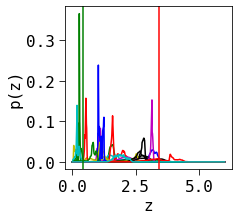

In [37]:
record = catalog[catalog["id"] == ID][0]

zlya = record["wl_com"]/1216. - 1.
zoii = record["wl_com"]/3727. - 1.

plot_phz(record["ra_com"],record["dec_com"],phz_zz, phz_pdz, zlya, zoii)



In [41]:
image_catalog = OrderedDict()
for b in gbimages:
        hdu = fits.open(gbimages[b])
        w = wcs.WCS(hdu[0].header)
        image_catalog[gbimages[b]] = [w, hdu[0].data.shape, "SUBARU", b]
        print(gbimages[b])

../aux/thumbnails/COSMOSC/ifu052_COSMOS.B.original_psf.v2.fits
../aux/thumbnails/COSMOSC/ifu052_COSMOS.V.original_psf.v2.fits
../aux/thumbnails/COSMOSC/ifu052_COSMOS.gp.original_psf.v2.fits
../aux/thumbnails/COSMOSC/ifu052_COSMOS.rp.original_psf.v2.fits
../aux/thumbnails/COSMOSC/ifu052_COSMOS.ip.original_psf.v2.fits
../aux/thumbnails/COSMOSC/ifu052_COSMOS.zp.original_psf.v2.fits
../aux/thumbnails/COSMOSC/ifu052_COSMOS.Ks.original_psf.v5.fits
../aux/thumbnails/COSMOSC/ifu052_COSMOS.K.UV_original_psf.v1.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [42]:
r = record


# GB images
# find the images that contain the detection
ra,dec = r["ra_com"], r["dec_com"]
images = OrderedDict()
for f in image_catalog:
    cos_term = np.cos(np.deg2rad(dec))
    _w,shape,t, b = image_catalog[f]

    x0,y0 = _w.wcs_world2pix(ra - width/2./cos_term ,dec-width/2.,0)
    x1,y1 = _w.wcs_world2pix(ra + width/2./cos_term, dec+width/2.,0)

    if x0 >= 0 and x1 >= 0 and x0 <= shape[1] and x1 <= shape[1]  \
        and y0 >= 0 and y1 >= 0 and y0 <= shape[0] and y1 <= shape[0]:
            images[f] = image_catalog[f]
                
                
print("foo")
for imcnt, filename in enumerate(images):
    if imcnt > 7:
        break

    photz_catalog = []
    #simbad_catalog = []
    if imcnt == 0:
        if False:
            # use SIMBAD
            simbad_catalog = query_simbad(ra,  dec, radius)
            cra  = [l[1] for l in simbad_catalog]
            cdec = [l[2] for l in simbad_catalog]
            cz   = [l[3] for l in simbad_catalog]

            photz_catalog = Table( [range(len(simbad_catalog)), cra, cdec, cz], names=["id", "ra","dec","z"] )
        else:
            fncatalog = "../pdz_cosmos2015_v1.3.fits"
            pzc = Table.read( fncatalog )
            photz_catalog = Table( [range(len(pzc)), pzc["RA"], pzc["DEC"], pzc["Z_MED_PDZ"]], \
                                  names=["id", "ra","dec","z"] )


            ra,dec = r["ra_com"], r["dec_com"]
            ii  = photz_catalog["ra"] > (ra  - 1./15.)
            ii *= photz_catalog["ra"] < (ra  + 1./15.)
            ii *= photz_catalog["dec"] > (dec - 1./15.)
            ii *= photz_catalog["dec"] < (dec + 1./15.)
            photz_catalog = photz_catalog[ii]


    _w, shape, t, b = images[filename]
    hdu = fits.open(filename)[0]
    _w = wcs.WCS(hdu.header)
    ax = plt.axes(convert(ax_pos["image{}".format(imcnt)]), projection=_w)

    vmin=-2.e-5
    vmax=10.
    if b in ['K','Ks']:
        vmax=50.
        print("Setting vmax to ", vmax)

    show_image(ax, r, hdu, _w, title = "{} {}".format(t,b), width = width, AXLABELS=False,\
               photz_catalog=photz_catalog,vmin=vmin,vmax=vmax)

    ax.contour(sl, transform=ax.get_transform(w),
               levels=[0.1,0.2,0.3,0.4], colors='grey', alpha=0.5)


foo


In [34]:
images

OrderedDict()

In [31]:
imcnt

0